## Table of content

1. [bproperty assessment](#bproperty-assessment) -> [Report summary](#bproperty-assessment-report)
1. [bproperty cleaning](#bproperty-cleaning)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from slugify import slugify
import os
import sys

sys.path.append("../functions")
from address_extractor import get_detailed_address

%matplotlib inline

In [2]:
#get_detailed_address("Dhaka, Dhaka, Rampura")

In [3]:
# """
#  The functions below are developed by one of the teammate from Omdena
# """

# def get_detailed_address(address):
#     address = address.title()
#     address_dict = {"City": "", "Area": "", "Address": ""}
#     splitted_address = address.split(',')

#     for i in reversed(splitted_address):
#         if get_city_name(i.strip()):
#             address_dict["City"] = i.strip()
#             splitted_address.remove(i)
#         elif get_area_name(i.strip()):
#             address_dict["Area"] = i.strip()
#             splitted_address.remove(i)

#     address_dict["Address"] = ','.join(splitted_address)

#     return address_dict


# def get_city_name(name):
#     cities = ['Dhaka', 'Chattogram', 'Narayanganj City', 'Gazipur', 'Sylhet']

#     try:
#         cities.index(name)
#         return True

#     except:
#         return False


# def get_area_name(name):

#     areas = ['10 No. North Kattali Ward', '11 No. South Kattali Ward', '15 No. Bagmoniram Ward',
#              '16 No. Chawk Bazaar Ward', '22 No. Enayet Bazaar Ward', '29 No. West Madarbari Ward',
#              '30 No. East Madarbari Ward', '31 No. Alkoron Ward', '32 No. Andarkilla Ward',
#              '33 No. Firingee Bazaar Ward', '36 Goshail Danga Ward', '4 No Chandgaon Ward',
#              '7 No. West Sholoshohor Ward', '9 No. North Pahartali Ward', 'Adabor', 'Aftab Nagar', 'Agargaon',
#              'Ambarkhana', 'Badda', 'Bakalia', 'Banani', 'Banani Dohs', 'Banasree', 'Banglamotors', 'Bangshal',
#              'Baridhara', 'Baridhara Dohs', 'Bashabo', 'Bashundhara R-A', 'Bayazid', 'Cantonment', 'Chandra',
#              'Dakshin Khan', 'Demra', 'Dhanmondi', 'Double Mooring', 'Dumni', 'East Nasirabad', 'Eskaton', 'Fatulla',
#              'Firojshah Colony', 'Gazipur Sadar Upazila', 'Gulistan', 'Gulshan', 'Halishahar', 'Hathazari', 'Hatirpool',
#              'Hazaribag', 'Ibrahimpur', 'Jalalabad Housing Society', 'Jamal Khan', 'Jatra Bari', 'Joar Sahara',
#              'Kachukhet', 'Kafrul', 'Kakrail', 'Kalabagan', 'Kalachandpur', 'Kamrangirchar', 'Kathalbagan',
#              'Kazir Dewri', 'Keraniganj', 'Khilgaon', 'Khilkhet', 'Khulshi', 'Kotwali', 'Kuril', 'Lal Khan Bazaar',
#              'Lalbagh', 'Lalmatia', 'Maghbazar', 'Malibagh', 'Maniknagar', 'Mirpur', 'Mohakhali', 'Mohakhali Dohs',
#              'Mohammadpur', 'Motijheel', 'Mugdapara', 'Muradpur', 'Nadda', 'Narayanganj', 'New Market', 'Niketan',
#              'Nikunja', 'North Shahjahanpur', 'Panchlaish', 'Paribagh', 'Patenga', 'Purbachal', 'Railway Colony',
#              'Rampura', 'Riaj Uddin Bazar', 'Sagorika Bscic Industrial Area', 'Savar', 'Shahbagh', 'Shahjahanpur',
#              'Shantinagar', 'Shegunbagicha', 'Shiddheswari', 'Shiddhirganj', 'Sholokbahar', 'Shyamoli', 'Shyampur',
#              'Sreepur', 'Sutrapur', 'Taltola', 'Tejgaon', 'Turag', 'Uttar Khan', 'Uttar Lalkhan', 'Uttara', 'Zafrabad',
#              'Zindabazar']


#     try:
#         areas.index(name)
#         return True

#     except:
#         return False

In [4]:
# CSV folders

raw_data_folder="../../../data/Raw_Data"
cleaned_data_folder="../../../data/CLeaned_Data"

bproperty_folder= f"{raw_data_folder}/bproperty_spider"
cleaned_bproperty_folder= f"{cleaned_data_folder}/bproperty"

In [5]:
target_df_dic = {
    "area":[],  # value in float, in sqft; 1 Katha = 720 sqft (Thanks @Kausthab Dutta Phukan)
    "building_type":[],
    "building_nature": [], # originally named commercial_type; value will be either Commercial or Residential
    
    # splitted from location column
    "city": [],
    "locality": [],
    "address":[],
    #"country": [],
    #"municipality":[],
    #"district":[],
    #...
    #"otherZoneArea":[], # create new column for any new zone information, and keep collaborators informed
    
    
    "num_bath_rooms":[], # for Commercial properties, give 0 as value (since that make sense), not NaN
    "num_bed_rooms":[], # for Commercial properties, give 0 as value (since that make sense), not NaN
    
    # convert currencies to BDT : 1 lakh=100000 BDT, 1 crore=10000000 BDT, 1 Arab= 1000000000 BDT (Thanks @Al Momin Faruk)
    "price": [], 
    
    "property_description":[],
    "property_overview":[],
    
    "purpose":[], # Either Rent/Sale
    
    # retrieved from amenities column: assuming in sample 1 amenities has {"k1":"v1","k2":"v2"} 
    #   and in sample 2 amenities has {"k3":"v3"}, we create new columns in the dataframe based on the keys of
    #   the dictionnaries
    "k1":[],
    "k2":[],
    "k3":[],
    
    # when any relevant column from other csv files is added, inform collaborators so that they follow the same principle
}

target_df = pd.DataFrame(target_df_dic)
target_df.T

""
area
building_type
building_nature
city
locality
address
num_bath_rooms
num_bed_rooms
price
property_description


<span id="bproperty-assessment"> </span>

## Assessing `bproperty_spider_2023-04-09T19-44-07`

In [6]:
bproperty_df=pd.read_csv(f"{bproperty_folder}/bproperty_spider_2023-04-18T01-34-24.csv")
bproperty_df.head().T

,0,1,2,3,4
amenities,"{'Balcony or Terrace': 'yes', 'Flooring': 'yes...","{'View': 'yes', 'Parking Spaces': ' 1', 'Balco...","{'View': 'yes', 'Balcony or Terrace': 'yes', '...","{'Parking Spaces': ' 1', 'Floor Level': 'yes',...","{'Flooring': 'yes', 'Parking Spaces': ' 1', 'B..."
area,"1,185 sqft","2,464 sqft","1,140 sqft","1,920 sqft","1,445 sqft"
building_type,Apartment,Apartment,Apartment,Apartment,Apartment
commercial_type,False,False,False,False,False
image_url,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...
location,"Khilgaon, Dhaka","Dhanmondi, Dhaka","Block TA, Section 6, Mirpur, Dhaka","Block J, Bashundhara R-A, Dhaka","Block M, South Banasree Project, Banasree, Dhaka"
num_bath_rooms,NaN,4 Baths,NaN,3 Baths,3 Baths
num_bed_rooms,3 Beds,3 Beds,3 Beds,3 Beds,3 Beds
price,61 Lakh,2.89 Crore,75 Lakh,2 Crore,1.08 Crore
property_description,Grab This 1185 Sq Ft Beautiful Flat Is Vacant ...,A Vibrant 2464 Sq Ft Residential Flat For Sale...,1140 Sq Ft Nicely Planned Apartment Is Availab...,A Modern Well-planned Apartment Of 1920 Sq Ft ...,"1445 Sq Ft Ready Flat For Sale In Banasree, Wi..."


In [7]:
bproperty_df.shape

(17329, 13)

In [8]:
bproperty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17329 entries, 0 to 17328
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   amenities             16438 non-null  object
 1   area                  17329 non-null  object
 2   building_type         17329 non-null  object
 3   commercial_type       17329 non-null  bool  
 4   image_url             17312 non-null  object
 5   location              17329 non-null  object
 6   num_bath_rooms        5691 non-null   object
 7   num_bed_rooms         12646 non-null  object
 8   price                 17329 non-null  object
 9   property_description  17329 non-null  object
 10  property_overview     17329 non-null  object
 11  property_url          17329 non-null  object
 12  purpose               17329 non-null  object
dtypes: bool(1), object(12)
memory usage: 1.6+ MB


* `area` column should be decimal, not string (quality issue)
* Replace column name `commercial_type` by `building_nature` (or any relevant name), and change its values to `residential` or `commercial` accordingly.  (quality issue)
* `location` is has concatened information: city, district, sector, etc. Those informations should be splitted in their relevant columns (column `city`, column `district`, ...). (tidiness issue)
* `num_bath_rooms` and `num_bed_rooms` should be decimal, no string. (quality issue)


In [9]:
bproperty_df["price"].unique()

array(['61 Lakh', '2.89 Crore', '75 Lakh', ..., '24 Crore', '7.3 Crore',
       '92.1 Lakh'], dtype=object)

* `price` content is not uniform accross the dataset. Some are in `Lakh`, other in `Crore`, etc... The unit used for the price should be uniformized. A special attention should be paid to the fact that there are `price` without unit (a solution need to be found for them). (quality issue)
* `price` should be decimal, not string

In [10]:
bproperty_df["property_description"][0]

'Grab This 1185 Sq Ft Beautiful Flat Is Vacant For Sale In Khilgaon'

In [11]:
bproperty_df["property_description"][15]

'Find 1522 Sq Ft Flat Available For Sale In Pallabi'

In [12]:
bproperty_df["property_overview"][0]

'This flat consists of facilities you can think of for a proper living standards. The amazing floor plan of this flat ensures the buyer decision even more rightful for what they are pursuing for. The washroom comes with all the up-to-date fixtures. For your delish cooking essentials, you are getting a convenient kitchen having a nice kitchen counter. You would also have refreshing balconies to spend some good family times in your morning and evening hours with your family. There are plenty of places nearby so going for recreational activities outside is an easy option to pick as well. Make yourself a happy buyer by calling us about this beautiful apartment right away!'

In [13]:
bproperty_df["property_overview"][150]

'This plot is designed with your desired home in mind. It will not only offer you a pleasant lifestyle but also will offer you complete privacy and security to ensure that your family and guests have a safe and enjoyable time. It also offers you a very good payment plan. This beautiful plot is now available with full building.  If you like the plot, call us right away to know more.'

In [14]:
property_per_purpose = bproperty_df["purpose"].value_counts()
property_per_purpose

For Sale    10943
For Rent     6386
Name: purpose, dtype: int64

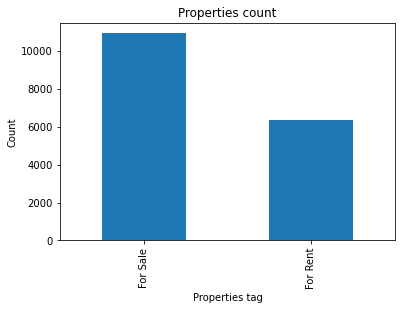

In [15]:
property_per_purpose.plot(kind="bar")
plt.xlabel("Properties tag")
plt.ylabel("Count")
plt.title("Properties count");

Properties for sale are nearly the double of the properties for rent. And the amount of properties may be a little low to make the futures model predict well on unknow data.

In [16]:
bproperty_df["amenities"][0]

"{'Balcony or Terrace': 'yes', 'Flooring': 'yes', 'Parking Spaces': ' 1', 'View': 'yes', 'Lobby in Building': 'yes', 'Electricity Backup': 'yes', 'Elevators in Building': ' 1', 'Floor Level': 'yes', 'CCTV Security': 'yes', 'Maintenance Staff': 'yes', 'Cleaning Services': 'yes'}"

In [17]:
bproperty_df["amenities"][220]

"{'Parking Spaces': ' 1', 'Flooring': 'yes', 'View': 'yes', 'Balcony or Terrace': 'yes', '24 Hours Concierge': 'yes', 'Double Glazed Windows': 'yes', 'Elevators in Building': ' 1', 'Floor Level': 'yes', 'Lobby in Building': 'yes', 'Broadband Internet': 'yes', 'Lawn or Garden': 'yes', 'CCTV Security': 'yes', 'Maintenance Staff': 'yes'}"

Each key in the dictionary of the feature `amenities` should become a column, with the following indications:
* `Floor level`: should be of type integer; its content should be the number of floor of the property
* `View`: should be of type boolean
* `Balcony or Terrace`: column should be named `balcony-or-terrace`, and should be of type boolean
* `Flooring`: should be of type boolean
* `Electricity backup`: column should be named `electricity-backup`, and should be of type boolean
* `Elevators in Buildings`: column should be named `elevator`, and should be of type int
* `Broadband Internet`: column should be named `internet`, and content should be boolean
* `CCTV Security`: column should be named `cctv-security`, and should be boolean
* `Cleaning Services`: column should be named `cleaning-services`, and should be boolean
* Keys present in the dictionary but not mentioned in the above list should also become a column

(tidiness issues)

In [18]:
bproperty_df["building_type"].unique()

array(['Apartment', 'Shop', 'Floor', 'Office', 'Building', 'Plot',
       'Duplex', 'Warehouse', 'Factory'], dtype=object)

In [19]:
bproperty_df["purpose"].unique()

array(['For Sale', 'For Rent'], dtype=object)

`purpose` should have `Rent` or `Sale` as values, to keep all cleaned datasets consistent.

<span id="bproperty-assessment-report"> </span>

#### Assessment report summary

##### Quality issues
1. `area` column should be decimal, not string.
1. Replace column name `commercial_type` by `building_nature`, and change its values to `residential` or `commercial` accordingly.
1. `num_bath_rooms` and `num_bed_rooms` should be decimal, no string.
1. `price` content is not uniform accross the dataset. Some are in `Lakh`, other in `Crore`, etc... The unit used for the price should be uniformized. Please pay attention to the fact that there are `price` without unit.
1. `price` should be decimal, not string
1. `purpose` should have `Rent` or `Sale` as values. This is not really an issue, its goal is only to keep values consistent accross all cleaned datasets.


##### Tidiness issues
1. `location` has concatened informations: city, district, sector, etc. Those informations will be splitted into `city` and `address`..
1. In `amenities` feature, each key in the dictionary should become a column, with the following indications:
    * `Floor level`:  column should be named `floor-level`, and should be of type integer; its content should be the number of floor of the property ??
    * `View`: should be of type boolean
    * `Balcony or Terrace`: column should be named `balcony-or-terrace`, and should be of type boolean
    * `Flooring`: should be of type boolean
    * `Electricity backup`: column should be named `electricity-backup`, and should be of type boolean
    * `Elevators in Buildings`: column should be named `elevator`, and should be of type int
    * `Broadband Internet`: column should be named `internet`, and content should be boolean
    * `CCTV Security`: column should be named `cctv-security`, and should be boolean
    * `Cleaning Services`: column should be named `cleaning-services`, and should be boolean
    * Keys present in the dictionary but not mentioned in the above list should also become a column
    

<span id="bproperty-cleaning"> </span>

## Cleaning `bproperty`

### `area` column should be decimal, not string ( [quality issue #1](#bproperty-assessment-report) )

In [20]:
# Recalling the type of area feature
bproperty_df["area"].dtype

dtype('O')

In [21]:
bproperty_df["area"].unique()

array(['1,185 sqft', '2,464 sqft', '1,140 sqft', ..., '3,842 sqft',
       '13,350 sqft', '307 sqft'], dtype=object)

There are value in `sqft` and in `Katha`

#### Define
* Loop through `area` column, while:
    * converting `Katha` value to `sqft` value
    * removing the unit in the value, to only have the number left
* Convert `area` column to decimal

#### Code

In [22]:
"""
    Loop through `area` column, while:
        - converting `Katha` value to `sqft` value
        - removing the unit in the value, to only have the number left
"""

for index, row in bproperty_df.iterrows(): # loop through each sample
    
    # The code may take time, log in the console to keep track of things
    if index==0 or index%1000==0:
        print(f"Currently processing sample {index}...")
        
    # retrieve the area
    sample_area = bproperty_df.loc[index, "area"] 
    splitted_sample_area = sample_area.split()
    
    # making sure there is only the value and the unit in sample_area
    if len(splitted_sample_area)>2:
        print(f"Sample of index {index} has a suspicious value as area: {sample_area}")
        break
        
    area = float( splitted_sample_area[0].replace(",","") ) # will contain the area; eg: 1345
    area_unit = splitted_sample_area[1].lower() # will contain the unit; eg: sqft
    
    # making sure all units are taken into account
    if area_unit not in ["sqft","katha"]:
        print(f"Sample of index {index} has a unit not taken into account for its area: {sample_area}")
        break
   
    # converting katha area to sqft area (1 Katha = 720 sqft => Thanks @Kausthab Dutta Phukan )
    if area_unit=="katha":
        area *= 720
        
    # updating the area of the sample in the dataframe
    bproperty_df.loc[index, "area"] = area
    
print("Processing has come to an end")

# Converting area to decimal
bproperty_df["area"] = bproperty_df["area"].astype(float)

Currently processing sample 0...
Currently processing sample 1000...
Currently processing sample 2000...
Currently processing sample 3000...
Currently processing sample 4000...
Currently processing sample 5000...
Currently processing sample 6000...
Currently processing sample 7000...
Currently processing sample 8000...
Currently processing sample 9000...
Currently processing sample 10000...
Currently processing sample 11000...
Currently processing sample 12000...
Currently processing sample 13000...
Currently processing sample 14000...
Currently processing sample 15000...
Currently processing sample 16000...
Currently processing sample 17000...
Processing has come to an end


#### Testing

In [23]:
bproperty_df["area"].dtype

dtype('float64')

### Cleaning `commercial_type` feature ( [quality issue #2](#bproperty-assessment-report) )

Replace column name `commercial_type` by `building_nature`, and change its values to `residential` or `commercial` accordingly.

In [24]:
bproperty_df["commercial_type"].unique()

array([False,  True])

#### Define
* Change column values: `True` is to be updated to `Commercial`, and `False` is to become `Residential`
* Replace column name (`commercial_type`) by `building_nature`

#### Code

In [25]:
# Replacing values of commercial_type column
bproperty_df.loc[ bproperty_df["commercial_type"]==True, ["commercial_type"] ] = "Commercial"
bproperty_df.loc[ bproperty_df["commercial_type"]==False, ["commercial_type"] ] = "Residential"

# Making sure values were updated
bproperty_df["commercial_type"].unique()

array(['Residential', 'Commercial'], dtype=object)

In [26]:
# Renaming column
bproperty_df.rename(columns={
    "commercial_type":"building_nature"
}, inplace=True)

# Confirming rename was done
bproperty_df.columns.to_list()

['amenities',
 'area',
 'building_type',
 'building_nature',
 'image_url',
 'location',
 'num_bath_rooms',
 'num_bed_rooms',
 'price',
 'property_description',
 'property_overview',
 'property_url',
 'purpose']

In [27]:
# Taking a look at content (for general confirmation)
bproperty_df.head(2).T

,0,1
amenities,"{'Balcony or Terrace': 'yes', 'Flooring': 'yes...","{'View': 'yes', 'Parking Spaces': ' 1', 'Balco..."
area,1185.0,2464.0
building_type,Apartment,Apartment
building_nature,Residential,Residential
image_url,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...
location,"Khilgaon, Dhaka","Dhanmondi, Dhaka"
num_bath_rooms,NaN,4 Baths
num_bed_rooms,3 Beds,3 Beds
price,61 Lakh,2.89 Crore
property_description,Grab This 1185 Sq Ft Beautiful Flat Is Vacant ...,A Vibrant 2464 Sq Ft Residential Flat For Sale...


### `num_bath_rooms` and `num_bed_rooms` should be integer, no string. ( [quality issue #3](#bproperty-assessment-report) )

In [28]:
bproperty_df["num_bath_rooms"].dtype

dtype('O')

In [29]:
bproperty_df["num_bath_rooms"].unique()

array([nan, '4 Baths', '3 Baths', '2 Baths', '10 Baths', '5 Baths',
       '8 Baths', '1 Bath', '7 Baths', '6 Baths', '9 Baths'], dtype=object)

In [30]:
bproperty_df["num_bed_rooms"].dtype

dtype('O')

In [31]:
bproperty_df["num_bed_rooms"].unique()

array(['3 Beds', '2 Beds', '4 Beds', nan, '21 Beds', '20 Beds', '5 Beds',
       '7 Beds', '1 Bed', '6 Beds', '19 Beds', '24 Beds', '33 Beds',
       '56 Beds', '18 Beds', '10 Beds', '13 Beds', '48 Beds', '12 Beds',
       '60 Beds', '40 Beds', '29 Beds', '23 Beds', '17 Beds', '14 Beds',
       '8 Beds', '50 Beds', '75 Beds', '42 Beds', '16 Beds', '36 Beds',
       '15 Beds', '25 Beds', '22 Beds', '46 Beds', '30 Beds', '11 Beds',
       '32 Beds', '94 Beds'], dtype=object)

#### Define
* Replace `NaN` values by `0` (since in this case, that made sense: it mean the sample doesn't have a bath_room or bed_room 
* Remove `Bed`, `Beds`, `Bath` and `Baths` from the values of `num_bed_rooms` and `num_bath_rooms`
* Convert `num_bed_rooms` and `num_bath_rooms` to integer

#### Code

In [32]:
# Replace NaN value by 0 in num_bed_rooms and num_bath_rooms
bproperty_df["num_bed_rooms"].fillna("0", inplace=True)
bproperty_df["num_bath_rooms"].fillna("0", inplace=True)

# Check that NaN values where replaced
bproperty_df["num_bed_rooms"].isnull().sum(), bproperty_df["num_bath_rooms"].isnull().sum()

(0, 0)

In [33]:
# Removing the units (bed, bath, ...) in num_bed_rooms and num_bath_rooms
bproperty_df["num_bed_rooms"] = bproperty_df["num_bed_rooms"].apply(lambda x: x.split(" ")[0] )
bproperty_df["num_bath_rooms"] = bproperty_df["num_bath_rooms"].apply(lambda x: x.split(" ")[0] )

In [34]:
# Converting num_bed_rooms and num_bath_rooms to integer
bproperty_df["num_bed_rooms"] = bproperty_df["num_bed_rooms"].astype(int)
bproperty_df["num_bath_rooms"] = bproperty_df["num_bath_rooms"].astype(int)


#### Testing

In [35]:
# Checking type conversion was succesful
bproperty_df["num_bed_rooms"].dtype, bproperty_df["num_bath_rooms"].dtype

(dtype('int32'), dtype('int32'))

### `price` content is not uniform accross the dataset ( [quality issue #4 & #5](#bproperty-assessment-report) )

`price` content is not uniform accross the dataset. Some are in `Lakh`, other in `Crore`, etc... The unit used for the price should be uniformized. A special attention should be paid to the fact that there are `price` without unit.  

Furthermore, `price` should be decimal, not string.

In [36]:
bproperty_df["price"].unique()

array(['61 Lakh', '2.89 Crore', '75 Lakh', ..., '24 Crore', '7.3 Crore',
       '92.1 Lakh'], dtype=object)

#### Define
* Convert all price to the same currency
* Replace `Thousand` by triple `0`
* Convert the column to float

#### Code

In [37]:
"""
    Loop through `price` column, while:
        * Converting all prices to BDT currency
        * Replacing `Thousand` by triple `0`
"""

for index, row in bproperty_df.iterrows(): # loop through each sample
    
    # The code may take time, log in the console to keep track of things
    if index==0 or index%1000==0:
        print(f"Currently processing sample {index}...")
        
    # retrieve the price
    sample_price = bproperty_df.loc[index, "price"]
    splitted_sample_price= sample_price.split()
    
    # making sure there are only the value and unit in sample price
    if len(splitted_sample_price)>2:
        print(f"Sample of index {index} has a suspicious value as price: {sample_price}")
        break
        
    price = float( splitted_sample_price[0] ) # will contain the price; eg: 1345
    price_unit = splitted_sample_price[1].lower() # will contain the unit; eg: Lakh, Crore
    
    # making sure all units are taken into account
    if price_unit not in ["arab","crore","lakh","thousand"]:
        print(f"Sample of index {index} has a unit not taken into account for its price: {sample_price}")
        break
    
    # converting all price unit to BDT : 1 lakh=100000 BDT,1 crore=10000000 BDT, 1 Arab= 1000000000 BDT (Thanks @Al Momin Faruk)
    if price_unit=="arab":
        price *= 1000000000
    elif price_unit=="crore":
        price *= 10000000
    elif price_unit=="lakh":
        price *= 100000
    elif price_unit=="thousand":
        price *= 1000
    else:
        raise Exception(f"Currency {price_unit} not taken to account")
    
    # updating the price of the sample in the dataframe
    bproperty_df.loc[index, "price"] = price

print("Processing has come to an end")
    
# Converting area to decimal
bproperty_df["price"] = bproperty_df["price"].astype(float)

Currently processing sample 0...
Currently processing sample 1000...
Currently processing sample 2000...
Currently processing sample 3000...
Currently processing sample 4000...
Currently processing sample 5000...
Currently processing sample 6000...
Currently processing sample 7000...
Currently processing sample 8000...
Currently processing sample 9000...
Currently processing sample 10000...
Currently processing sample 11000...
Currently processing sample 12000...
Currently processing sample 13000...
Currently processing sample 14000...
Currently processing sample 15000...
Currently processing sample 16000...
Currently processing sample 17000...
Processing has come to an end


#### Testing

In [38]:
bproperty_df["price"].dtype

dtype('float64')

### Set `purpose` values to `Rent` or `Sale` ( [quality issue #6](#bproperty-assessment-report) )

`purpose` should have `Rent` or `Sale` as values. This is not really an issue, its goal is only to keep values consistent accross all cleaned datasets.

In [39]:
bproperty_df["purpose"].unique()

array(['For Sale', 'For Rent'], dtype=object)

#### Define
* Replace `For Sale` by `Sale`, and `For Rent` by `Rent` 

#### Code

In [40]:
bproperty_df["purpose"] = bproperty_df["purpose"].apply(lambda x: x.split(" ")[1] )

#### Testing

In [41]:
bproperty_df["purpose"].unique()

array(['Sale', 'Rent'], dtype=object)

### Split `location` column content into adequate columns ( [tidiness issue #1](#bproperty-assessment-report) )

`location` has concatened informations: city, district, sector, etc. Those will be splitted into `city` and `address`.

In [42]:
bproperty_df["location"]

0                                         Khilgaon, Dhaka
1                                        Dhanmondi, Dhaka
2                      Block TA, Section 6, Mirpur, Dhaka
3                         Block J, Bashundhara R-A, Dhaka
4        Block M, South Banasree Project, Banasree, Dhaka
                               ...                       
17324                            Block H, Banasree, Dhaka
17325                     Block J, Bashundhara R-A, Dhaka
17326                     Block G, Bashundhara R-A, Dhaka
17327                               Baridhara DOHS, Dhaka
17328                            Block F, Banasree, Dhaka
Name: location, Length: 17329, dtype: object

#### Define
* Before
    * Split content of `location` to `city` and `address`
    * Remove `location` column
* Now
    * Retrieve the city, area, and address from each `location` through `get_detailed_address()`
    * Update new columns (city, locality, address) based on values retrieve from `location`

#### Code

In [43]:
# testing the get_detailed_address
get_detailed_address(bproperty_df["location"][0])

{'City': 'Dhaka', 'Area': 'Khilgaon', 'Address': ''}

In [44]:
# bproperty_df["location"][13].title()

In [45]:
# Create new columns
bproperty_df["city"] = np.NaN
bproperty_df["locality"] = np.NaN
bproperty_df["address"] = np.nan

# Check new columns
bproperty_df.head(3).T

,0,1,2
amenities,"{'Balcony or Terrace': 'yes', 'Flooring': 'yes...","{'View': 'yes', 'Parking Spaces': ' 1', 'Balco...","{'View': 'yes', 'Balcony or Terrace': 'yes', '..."
area,1185.0,2464.0,1140.0
building_type,Apartment,Apartment,Apartment
building_nature,Residential,Residential,Residential
image_url,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...
location,"Khilgaon, Dhaka","Dhanmondi, Dhaka","Block TA, Section 6, Mirpur, Dhaka"
num_bath_rooms,0,4,0
num_bed_rooms,3,3,3
price,6100000.0,28900000.0,7500000.0
property_description,Grab This 1185 Sq Ft Beautiful Flat Is Vacant ...,A Vibrant 2464 Sq Ft Residential Flat For Sale...,1140 Sq Ft Nicely Planned Apartment Is Availab...


In [46]:
# Old code

# # Retrieve city in location
# bproperty_df["city"] = bproperty_df["location"].apply(lambda x: x.split(",")[-1].strip() )

# # Retrieve address in location
# bproperty_df["address"] = bproperty_df["location"].apply(lambda x: ",".join(x.split(",")[:-1]).strip() )

# # Checking the content of location, city, and address
# bproperty_df[ ["location","city","address"] ] 

In [47]:
# New code

"""
    Loop through `location` column, while splitting each location to city, zone, address and add them
        to the relevant column
"""

for index, row in bproperty_df.iterrows(): # loop through each sample
    
    # The code may take time, log in the console to keep track of things
    if index==0 or index%1000==0:
        print(f"Currently processing sample {index}...")
        
    # retrieve the location
    location = bproperty_df.loc[index, "location"]
    
    # split the location to dictionary with Area, City, Address as keys
    location_dict = get_detailed_address(location)
    
    city = location_dict.get("City", np.NaN)
    locality = location_dict.get("Area", np.NaN)
    address = location_dict.get("Address", np.NaN)
    

    # updating the relevant columns of the sample in the dataframe
    bproperty_df.loc[index, "city"] = city
    bproperty_df.loc[index, "locality"] = locality
    bproperty_df.loc[index, "address"] = address

print("Processing has come to an end")

Currently processing sample 0...
Currently processing sample 1000...
Currently processing sample 2000...
Currently processing sample 3000...
Currently processing sample 4000...
Currently processing sample 5000...
Currently processing sample 6000...
Currently processing sample 7000...
Currently processing sample 8000...
Currently processing sample 9000...
Currently processing sample 10000...
Currently processing sample 11000...
Currently processing sample 12000...
Currently processing sample 13000...
Currently processing sample 14000...
Currently processing sample 15000...
Currently processing sample 16000...
Currently processing sample 17000...
Processing has come to an end


In [48]:
# Making sure the columns were splitted efficiently
bproperty_df[ ["location","city","locality","address"] ]

,location,city,locality,address
0,"Khilgaon, Dhaka",Dhaka,Khilgaon,
1,"Dhanmondi, Dhaka",Dhaka,Dhanmondi,
2,"Block TA, Section 6, Mirpur, Dhaka",Dhaka,Mirpur,"Block Ta, Section 6"
3,"Block J, Bashundhara R-A, Dhaka",Dhaka,Bashundhara R-A,Block J
4,"Block M, South Banasree Project, Banasree, Dhaka",Dhaka,Banasree,"Block M, South Banasree Project"
...,...,...,...,...
17324,"Block H, Banasree, Dhaka",Dhaka,Banasree,Block H
17325,"Block J, Bashundhara R-A, Dhaka",Dhaka,Bashundhara R-A,Block J
17326,"Block G, Bashundhara R-A, Dhaka",Dhaka,Bashundhara R-A,Block G
17327,"Baridhara DOHS, Dhaka",Dhaka,Baridhara Dohs,


In [49]:
bproperty_df.shape

(17329, 16)

In [50]:
# Drop location column
bproperty_df.drop(["location"], axis=1, inplace=True)

In [51]:
# Making sure removal was successful
bproperty_df.shape

(17329, 15)

### Cleaning `amenities` feature ( [tidiness issue #2](#bproperty-assessment-report) )

In `amenities` feature, each key in the dictionaries (in its content) should become a column. The value of the key should become the sample value corresponding to that column.

In [52]:
bproperty_df["amenities"][0]

"{'Balcony or Terrace': 'yes', 'Flooring': 'yes', 'Parking Spaces': ' 1', 'View': 'yes', 'Lobby in Building': 'yes', 'Electricity Backup': 'yes', 'Elevators in Building': ' 1', 'Floor Level': 'yes', 'CCTV Security': 'yes', 'Maintenance Staff': 'yes', 'Cleaning Services': 'yes'}"

In [53]:
bproperty_df["amenities"][12]

"{'View': 'yes', 'Parking Spaces': ' 1', 'Floor Level': 'yes', 'Balcony or Terrace': 'yes', 'Lobby in Building': 'yes', 'Electricity Backup': 'yes', 'Flooring': 'yes', 'Elevators in Building': ' 1', 'Maintenance Staff': 'yes', 'Cleaning Services': 'yes'}"

#### Define
* Keys in the dictionaries of `amenities` will become new columns in the dataset; the values of the keys will become the new columns values for the corresponding sample.

#### Code

In [54]:
"""
    Loop through `amenities` column, while:
         * Converting the dictionnaries keys to new columns; the values of the keys are becoming
             the new columns values for the corresponding sample
"""

for index, row in bproperty_df.iterrows(): # loop through each sample
    
    # The code may take time, log in the console to keep track of things
    if index==0 or index%1000==0:
        print(f"Currently processing sample {index}...")
        
    # If current sample doen't have amenities, go to the next one
    if pd.isna(bproperty_df.loc[index, "amenities"]):
        continue
    
    # retrieve the amenities
    sample_amenities = str(bproperty_df.loc[index, "amenities"]).replace("'","\"")
    
    amenities_dict = eval(sample_amenities)
    
    # Go through each key in the amenities dictionnary
    for key, value in amenities_dict.items():
        
        # put a suffix to the new column name, so that collaborators know it was generated from amenities feature
        column_name = slugify(key)+"-amenity"
        #print(column_name)
        
        # Create new column based on the key if not already existing
        if column_name not in bproperty_df.columns.to_list():
            bproperty_df[column_name]= np.NaN # Giving NaN as the default value for the column
        
        # Affecting to the new column created, for the current sample, the value of the dictionary's key
        bproperty_df.loc[index, column_name] = value
        

Currently processing sample 0...
Currently processing sample 1000...
Currently processing sample 2000...
Currently processing sample 3000...
Currently processing sample 4000...
Currently processing sample 5000...
Currently processing sample 6000...
Currently processing sample 7000...
Currently processing sample 8000...
Currently processing sample 9000...
Currently processing sample 10000...
Currently processing sample 11000...
Currently processing sample 12000...
Currently processing sample 13000...
Currently processing sample 14000...
Currently processing sample 15000...
Currently processing sample 16000...
Currently processing sample 17000...


In [55]:
# Checking columns
bproperty_df.head(3).T

,0,1,2
amenities,"{'Balcony or Terrace': 'yes', 'Flooring': 'yes...","{'View': 'yes', 'Parking Spaces': ' 1', 'Balco...","{'View': 'yes', 'Balcony or Terrace': 'yes', '..."
area,1185.0,2464.0,1140.0
building_type,Apartment,Apartment,Apartment
building_nature,Residential,Residential,Residential
image_url,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...
num_bath_rooms,0,4,0
num_bed_rooms,3,3,3
price,6100000.0,28900000.0,7500000.0
property_description,Grab This 1185 Sq Ft Beautiful Flat Is Vacant ...,A Vibrant 2464 Sq Ft Residential Flat For Sale...,1140 Sq Ft Nicely Planned Apartment Is Availab...
property_overview,This flat consists of facilities you can think...,Ready to move in somewhere with everything nea...,A spacious 1140 Square Feet apartment in Mirp...


In [56]:
# Drop amenities column
bproperty_df.drop(["amenities"],axis=1, inplace=True)

# Check that removal was effective
"amenities" in bproperty_df.columns.to_list()

False

### Save cleaned dataset

In [57]:
# Create folder in which to save cleaned dataset
if not os.path.exists(cleaned_bproperty_folder):
    os.makedirs(cleaned_bproperty_folder)
    print(f"Create folder '{cleaned_bproperty_folder}'")
else:
    print(f"Folder '{cleaned_bproperty_folder}' already exists")

Create folder '../../../data/CLeaned_Data/bproperty'


In [58]:
# Save cleaned dataset to csv
bproperty_df.to_csv(f"{cleaned_bproperty_folder}/cleaned_bproperty.csv", index=False)

In [59]:
# Load saved csv (to make sure it was successfully save)
clean_bproperty_df = pd.read_csv(f"{cleaned_bproperty_folder}/cleaned_bproperty.csv")
clean_bproperty_df.head(3).T

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2
area,1185.0,2464.0,1140.0
building_type,Apartment,Apartment,Apartment
building_nature,Residential,Residential,Residential
image_url,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...,https://images-cdn.bproperty.com/thumbnails/15...
num_bath_rooms,0,4,0
num_bed_rooms,3,3,3
price,6100000.0,28900000.0,7500000.0
property_description,Grab This 1185 Sq Ft Beautiful Flat Is Vacant ...,A Vibrant 2464 Sq Ft Residential Flat For Sale...,1140 Sq Ft Nicely Planned Apartment Is Availab...
property_overview,This flat consists of facilities you can think...,Ready to move in somewhere with everything nea...,A spacious 1140 Square Feet apartment in Mirp...
property_url,https://www.bproperty.com/en/property/details-...,https://www.bproperty.com/en/property/details-...,https://www.bproperty.com/en/property/details-...
